# Import Libraries and Configure GPU

In [1]:
import os
import re
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from tqdm import tqdm


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Preventing memory growth issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Using the first available GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU detected and will be used for training.")
        print("Available GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training will be performed on CPU.")


2025-02-02 23:03:19.306259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738524799.335093    6436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738524799.342139    6436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 23:03:19.363777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU detected and will be used for training.
Available GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import yaml

# Load config file
with open('../configs/config2.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# Extract parameters
EPOCHS = config['training']['epochs']
PATIENCE = config['training']['patience']
BATCH_SIZE = config['training']['batch_size']
LEARNING_RATE = config['training']['learning_rate']

In [3]:

def create_exp_folder(config):
    # Generate folder name based on key parameters
    exp_folder_name = f"experiments/epochs{config['training']['epochs']}_pat{config['training']['patience']}_val{config['training']['val_ratio']}"
    
    # Create the directory
    os.makedirs(exp_folder_name, exist_ok=True)
    
    results_folder_name = f"{exp_folder_name}/results"
    os.makedirs(results_folder_name, exist_ok=True)
    
    # Save a copy of the config file in the folder
    config_path = os.path.join(exp_folder_name, "used_config.yaml")
    with open(config_path, 'w') as f:
        yaml.dump(config, f)
    
    # Create a parameter summary file
    param_summary = os.path.join(exp_folder_name, "parameters.txt")
    with open(param_summary, 'w') as f:
        f.write("===== Training Parameters =====\n")
        for key, value in config['training'].items():
            f.write(f"{key}: {value}\n")
        f.write("\n===== Data Parameters =====\n")
        for key, value in config['data'].items():
            f.write(f"{key}: {value}\n")
    
    return exp_folder_name, results_folder_name

# Before calling model.fit()
exp_folder, results_folder = create_exp_folder(config)
print(f"files will be saved in: {exp_folder}")

checkpoint_path = os.path.join(exp_folder, "PCnnLstm_checkpoint.keras")
last_epoch_file = os.path.join(exp_folder, "last_epoch.txt")
log_file = os.path.join(exp_folder, "training_log.txt")


files will be saved in: experiments/epochs5_pat10_val0.25


# Data Loading Functions

In [4]:
from natsort import natsorted

def load_processed_data(folder_path):
    """
    Load all processed Excel files from a given folder in numerical sorted order and combine them into a single DataFrame.
    """
    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder {folder_path} does not exist.")

    # Get list of Excel files and sort them numerically
    files = natsorted([file for file in os.listdir(folder_path) if file.endswith('.xlsx')])
    # print(files)
    if not files:
        raise ValueError(f"No Excel files found in the folder: {folder_path}")

    dataframes = []

    # Load each file in the sorted order
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_excel(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"Loaded {len(files)} files with a total of {combined_df.shape[0]} rows.")
        return combined_df
    else:
        raise ValueError("No valid data could be loaded from the folder.")

def load_all_folders(folder_paths):
    """
    Load processed data from multiple folders and combine them into a single DataFrame.
    """
    all_dataframes = []

    for folder_path in folder_paths:
        try:
            print(f"Loading data from folder: {folder_path}")
            df = load_processed_data(folder_path)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error loading data from folder {folder_path}: {e}")

    # Concatenate all DataFrames from the folders
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Total combined data shape: {combined_df.shape}")
        return combined_df
    else:
        raise ValueError("No valid data could be loaded from the provided folders.")

# Data Processing and Normalization

In [5]:
# Define the sequence length
sequence_length = config['data']['sequence_length']  # Number of points for calculating moving average and integral

# List of training folder paths
train_data_folders = config['training']['train_data_folders']

# List of testing folder paths
test_data_folders = config['testing']['test_data_folders']

# Load train and test data from multiple folders
try:
    train_data = load_all_folders(train_data_folders)
    test_data = load_all_folders(test_data_folders)
    print("Train and test data successfully loaded.")
except Exception as e:
    print(f"Error loading data: {e}")

# Define features and target variable
features = config['data']['features']

target = config['data']['target']

test_original_data = test_data.copy()

# Normalize the data
print("\nNormalizing Data...")
scaler = StandardScaler()
try:
    train_data[features + [target]] = scaler.fit_transform(train_data[features + [target]])
    test_data[features + [target]] = scaler.transform(test_data[features + [target]])
    print("Data normalization complete.")
except Exception as e:
    print(f"Error during normalization: {e}")
    raise


# Reset index after concatenation
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Loading data from folder: /mnt/60FE87C2FE878F4A/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/OXFORD/dataset/Cell1_Files
Loaded 156 files with a total of 468674 rows.
Total combined data shape: (468674, 4)
Loading data from folder: /mnt/60FE87C2FE878F4A/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/OXFORD/dataset/Cell2_Files
Loaded 146 files with a total of 434300 rows.
Total combined data shape: (434300, 4)
Train and test data successfully loaded.

Normalizing Data...
Data normalization complete.


# Sequence Creation and Dataset Preparation

In [7]:
# Function to create sequences from data
def create_sequences(data, features, target, sequence_length):
    """
    Creates sequences of data for model training/testing.
    """
    X, y = [], []
    for i in tqdm(range(len(data) - sequence_length), desc="Creating Sequences", unit="sequence"):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])
    return np.array(X), np.array(y)


def create_sequences_original(data, features, target, sequence_length, batch_size=5000):
    """
    Creates sequences of raw data for testing in batches to save memory.
    """
    X, y = [], []
    num_batches = len(data) // batch_size + 1  # تعداد دسته‌ها
    for batch_idx in tqdm(range(num_batches), desc="Processing Batches"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(data))
        batch_data = data.iloc[start_idx:end_idx]
        
        # پردازش هر دسته
        for i in range(len(batch_data) - sequence_length):
            X.append(batch_data[features].iloc[i:i + sequence_length].values)
            y.append(batch_data[target].iloc[i + sequence_length])

    return np.array(X), np.array(y)


# Function to create sequences and save/load them
def prepare_sequences(data, features, target, sequence_length, dataset_type='train'):
    """
    Prepares sequences for model training or testing.
    """
    X, y = create_sequences(data, features, target, sequence_length)
    # Save the data for later use
    np.save(f'../npy_files/X_{dataset_type}.npy', X)
    np.save(f'../npy_files/y_{dataset_type}.npy', y)
    print(f"{dataset_type.capitalize()} sequences created and saved.")
    return X, y

# Prepare training sequences
print("\nPreparing Training Sequences...")
if os.path.exists('../npy_files/X_train.npy') and os.path.exists('../npy_files/y_train.npy'):
    print("Loading train data from files...")
    X_train = np.load('../npy_files/X_train.npy')
    y_train = np.load('../npy_files/y_train.npy')
else:
    X_train, y_train = prepare_sequences(train_data, features, target, sequence_length, dataset_type='train')

# Prepare testing sequences
print("\nPreparing Testing Sequences...")
if os.path.exists('../npy_files/X_test.npy') and os.path.exists('../npy_files/y_test.npy'):
    print("Loading test data from files...")
    X_test = np.load('../npy_files/X_test.npy')
    y_test = np.load('../npy_files/y_test.npy')
else:
    X_test, y_test = prepare_sequences(test_data, features, target, sequence_length, dataset_type='test')


print("\nPreparing Original Testing Sequences...")
if os.path.exists('../npy_files/X_test_original.npy') and os.path.exists('../npy_files/y_test_original.npy'):
    print("Loading original test data from files...")
    X_test_original = np.load('../npy_files/X_test_original.npy')
    y_test_original = np.load('../npy_files/y_test_original.npy')
else:
    X_test_original, y_test_original = create_sequences_original(
        test_original_data, 
        features, 
        target, 
        sequence_length=30, 
        batch_size=5000
    )
    np.save('../npy_files/X_test_original.npy', X_test_original)
    np.save('../npy_files/y_test_original.npy', y_test_original)

# Create TensorFlow datasets
print("\nCreating TensorFlow Datasets...")
batch_size = BATCH_SIZE

print(len(X_train))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

print("Training and testing datasets are ready for modeling.")



Preparing Training Sequences...
Loading train data from files...

Preparing Testing Sequences...
Loading test data from files...

Preparing Original Testing Sequences...
Loading original test data from files...

Creating TensorFlow Datasets...
468644


I0000 00:00:1738524882.900378    6436 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2787 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Training and testing datasets are ready for modeling.


# PCNN-LSTM Model Definition

In [8]:
# Define the model architecture
def build_pcnn_lstm_model(input_shape, output_size=1):
    inputs = layers.Input(shape=input_shape)  # (seq_len, input_size)

    # CNN Branch
    x_cnn = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
    x_cnn = layers.BatchNormalization()(x_cnn)
    x_cnn = layers.MaxPooling1D(pool_size=2, strides=1)(x_cnn)
    x_cnn = layers.Flatten()(x_cnn)  # (batch_size, features)

    # LSTM Branch
    x_lstm = layers.LSTM(200, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x_lstm = layers.BatchNormalization()(x_lstm)
    x_lstm = layers.LSTM(100, activation='tanh', recurrent_activation='sigmoid', unroll=True)(x_lstm)

    # Concatenate CNN and LSTM branches
    x = layers.concatenate([x_cnn, x_lstm])  # Flatten already handled

    # Fully Connected Layers
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(output_size)(x)  # For regression

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (sequence_length, len(features))
output_size = 1  # For regression

model = build_pcnn_lstm_model(input_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 16)    │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 16)    │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 200)   │    162,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 27, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 200)   │        800 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 432)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │    120,400 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 532)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │    106,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     20,100 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     10,100 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        101 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 420,677 (1.60 MB)

 Trainable params: 420,245 (1.60 MB)

 Non-trainable params: 432 (1.69 KB)

# Model Training and Callbacks

In [9]:
# Configure logging to output to both console and file
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()  # Also display output in console
    ]
)
logger = logging.getLogger()

# Split training data into train and validation sets
logger.info("Splitting training data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=config['training']['val_ratio'], random_state=42)
logger.info(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)


# Custom callback to log detailed epoch information
class LoggingCallback(callbacks.Callback):
    def on_train_begin(self, logs=None):
        logger.info("Training started.")

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            log_message = f"Epoch {epoch + 1}/{self.params['epochs']} completed."
            for key, value in logs.items():
                log_message += f" - {key}: {value:.4f}"
            logger.info(log_message)
        else:
            logger.info(f"Epoch {epoch + 1}/{self.params['epochs']} completed.")
        logger.info("\n")
    def on_train_end(self, logs=None):
        logger.info("Training completed.")

# Custom callback to log saving model
class CustomModelCheckpoint(callbacks.ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        # Check if 'val_loss' improved
        if logs and logs.get('val_loss') == self.best:
            logger.info(
                f"Epoch {epoch + 1}: val_loss improved to {logs['val_loss']:.4f}, saving model to {self.filepath}."
            )
            # Save the last completed epoch
            with open(last_epoch_file, "w") as f:
                f.write(str(epoch + 1))  # Save the next epoch to start from

# Load checkpoint if exists
initial_epoch = 0
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    logger.info("Checkpoint loaded. Resuming training...")
    if os.path.exists(last_epoch_file):
        with open(last_epoch_file, "r") as f:
            initial_epoch = int(f.read().strip())
        logger.info(f"Resuming training from epoch {initial_epoch}.")
else:
    logger.warning("No checkpoint found. Training will start from scratch.")

# Initialize callbacks
checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,  # Start from the last saved epoch
    callbacks=[checkpoint_callback, early_stopping_callback, LoggingCallback()],
    verbose=1
)

# Extract history for training and validation
train_loss_history = history.history['loss']
train_mae_history = history.history['mae']
train_rmse_history = history.history['rmse']

val_loss_history = history.history['val_loss']
val_mae_history = history.history['val_mae']
val_rmse_history = history.history['val_rmse']

# Log the final history in columnar format
logger.info("\nTraining and Validation History:")
logger.info(f"{'Epoch':<6}{'Train Loss':<15}{'Train MAE':<15}{'Train RMSE':<15}{'Val Loss':<15}{'Val MAE':<15}{'Val RMSE':<15}")
for i, (t_loss, t_mae, t_rmse, v_loss, v_mae, v_rmse) in enumerate(
        zip(train_loss_history, train_mae_history, train_rmse_history,
            val_loss_history, val_mae_history, val_rmse_history), 1):
    logger.info(f"{i:<6}{t_loss:<15.4f}{t_mae:<15.4f}{t_rmse:<15.4f}{v_loss:<15.4f}{v_mae:<15.4f}{v_rmse:<15.4f}")



Splitting training data into training and validation sets...
Training samples: 351483, Validation samples: 117161
No checkpoint found. Training will start from scratch.
Training started.


Epoch 1/5


I0000 00:00:1738524911.219908    6642 service.cc:148] XLA service 0x74b320013f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738524911.220014    6642 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-02-02 23:05:11.535097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738524913.774654    6642 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-02 23:05:20.328109: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


   14/10984 ━━━━━━━━━━━━━━━━━━━━ 1:36 9ms/step - loss: 1.3004 - mae: 0.6859 - rmse: 1.1321  

I0000 00:00:1738524925.870849    6642 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10984/10984 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0420 - mae: 0.2703 - rmse: 1.0206
Epoch 1: val_loss improved from inf to 0.93756, saving model to experiments/epochs5_pat10_val0.25/PCnnLstm_checkpoint.keras


Epoch 1: val_loss improved to 0.9376, saving model to experiments/epochs5_pat10_val0.25/PCnnLstm_checkpoint.keras.
Epoch 1/5 completed. - loss: 1.0157 - mae: 0.2525 - rmse: 1.0078 - val_loss: 0.9376 - val_mae: 0.2127 - val_rmse: 0.9683




10984/10984 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - loss: 1.0420 - mae: 0.2703 - rmse: 1.0206 - val_loss: 0.9376 - val_mae: 0.2127 - val_rmse: 0.9683
Epoch 2/5
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0196 - mae: 0.2552 - rmse: 1.0097
Epoch 2: val_loss did not improve from 0.93756


Epoch 2/5 completed. - loss: 1.0053 - mae: 0.2529 - rmse: 1.0026 - val_loss: 0.9396 - val_mae: 0.2142 - val_rmse: 0.9693




10984/10984 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - loss: 1.0196 - mae: 0.2552 - rmse: 1.0097 - val_loss: 0.9396 - val_mae: 0.2142 - val_rmse: 0.9693
Epoch 3/5
10979/10984 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0129 - mae: 0.2559 - rmse: 1.0063
Epoch 3: val_loss improved from 0.93756 to 0.93568, saving model to experiments/epochs5_pat10_val0.25/PCnnLstm_checkpoint.keras


Epoch 3: val_loss improved to 0.9357, saving model to experiments/epochs5_pat10_val0.25/PCnnLstm_checkpoint.keras.
Epoch 3/5 completed. - loss: 1.0033 - mae: 0.2539 - rmse: 1.0016 - val_loss: 0.9357 - val_mae: 0.2500 - val_rmse: 0.9673




10984/10984 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 1.0129 - mae: 0.2559 - rmse: 1.0063 - val_loss: 0.9357 - val_mae: 0.2500 - val_rmse: 0.9673
Epoch 4/5
10978/10984 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0176 - mae: 0.2562 - rmse: 1.0086
Epoch 4: val_loss improved from 0.93568 to 0.93536, saving model to experiments/epochs5_pat10_val0.25/PCnnLstm_checkpoint.keras


Epoch 4: val_loss improved to 0.9354, saving model to experiments/epochs5_pat10_val0.25/PCnnLstm_checkpoint.keras.
Epoch 4/5 completed. - loss: 1.0023 - mae: 0.2524 - rmse: 1.0011 - val_loss: 0.9354 - val_mae: 0.2437 - val_rmse: 0.9671




10984/10984 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 1.0175 - mae: 0.2562 - rmse: 1.0086 - val_loss: 0.9354 - val_mae: 0.2437 - val_rmse: 0.9671
Epoch 5/5
10978/10984 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0142 - mae: 0.2541 - rmse: 1.0068
Epoch 5: val_loss did not improve from 0.93536


Epoch 5/5 completed. - loss: 1.0034 - mae: 0.2506 - rmse: 1.0017 - val_loss: 0.9355 - val_mae: 0.2320 - val_rmse: 0.9672




10984/10984 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 1.0142 - mae: 0.2541 - rmse: 1.0068 - val_loss: 0.9355 - val_mae: 0.2320 - val_rmse: 0.9672
Restoring model weights from the end of the best epoch: 4.


Training completed.

Training and Validation History:
Epoch Train Loss     Train MAE      Train RMSE     Val Loss       Val MAE        Val RMSE       
1     1.0157         0.2525         1.0078         0.9376         0.2127         0.9683         
2     1.0053         0.2529         1.0026         0.9396         0.2142         0.9693         
3     1.0033         0.2539         1.0016         0.9357         0.2500         0.9673         
4     1.0023         0.2524         1.0011         0.9354         0.2437         0.9671         
5     1.0034         0.2506         1.0017         0.9355         0.2320         0.9672         


In [10]:
def representative_dataset_generator():
        """
        Creates a representative dataset for TFLite model quantization.

        This function generates batches of data from the training or testing dataset
        to help TFLite model quantization process understand the input distribution.

        Yields:
            A single batch of input data for the model (as a numpy array).
        """
        for i in tqdm(range(len(X_test))):
            # Use only one sample at a time, as required by TFLite quantization
            sample = X_test[i:i+1].astype(np.float32)
            yield [sample]


# Load the saved Keras model from file
model_path = checkpoint_path  # Replace with the path to your model
model = tf.keras.models.load_model(model_path)

# Pass this function to the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_generator

# Specify the input and output types as int8
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]
converter.target_spec.supported_types = [tf.int8]

tflite_model = converter.convert()

with open(os.path.join(exp_folder, "model.tflite"), "wb") as f:
    f.write(tflite_model)

    # Load the TFLite model
tflite_model_path = os.path.join(exp_folder, "model.tflite")
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== Input Details ===")
for i, detail in enumerate(input_details):
    print(f"Input {i}:")
    print(f"  Name: {detail['name']}")
    print(f"  Shape: {detail['shape']}")
    print(f"  Data Type: {detail['dtype']}")

print("\n=== Output Details ===")
for i, detail in enumerate(output_details):
    print(f"Output {i}:")
    print(f"  Name: {detail['name']}")
    print(f"  Shape: {detail['shape']}")
    print(f"  Data Type: {detail['dtype']}")

# Get all layer details (Optional)
print("\n=== Tensor Details ===")
for tensor in interpreter.get_tensor_details():
    print(f"Tensor Name: {tensor['name']}")
    print(f"  Index: {tensor['index']}")
    print(f"  Shape: {tensor['shape']}")
    print(f"  Data Type: {tensor['dtype']}")
    print()

tensor_details = interpreter.get_tensor_details()
total_memory = 0

for tensor in tensor_details:
    tensor_shape = tensor['shape']
    tensor_type = tensor['dtype']
    tensor_size = tf.dtypes.as_dtype(tensor_type).size * tf.reduce_prod(tensor_shape)
    total_memory += tensor_size.numpy()

print(f"Total Memory Required: {total_memory} bytes")



Function `function` contains input name(s) resource with unsupported characters which will be renamed to functional_1_dense_3_1_add_readvariableop_resource in the SavedModel.
Function `function` contains input name(s) resource with unsupported characters which will be renamed to functional_1_dense_3_1_add_readvariableop_resource in the SavedModel.


INFO:tensorflow:Assets written to: /tmp/tmp8hu19jgi/assets


Assets written to: /tmp/tmp8hu19jgi/assets


Saved artifact at '/tmp/tmp8hu19jgi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136174085978448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136174085976688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816344144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816348016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816348368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816337104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816342736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816335520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136173816338160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136174086677152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136174086678384: Tens

/home/matin/uni/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/ubuntu_venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1738398407.241681   19328 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1738398407.241696   19328 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-01 11:56:47.242100: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8hu19jgi
2025-02-01 11:56:47.245327: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-01 11:56:47.245399: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8hu19jgi
I0000 00:00:1738398407.293090   19328 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-01 11:56:47.297958: I ten

=== Input Details ===
Input 0:
  Name: serving_default_input_layer:0
  Shape: [ 1 30  2]
  Data Type: <class 'numpy.float32'>

=== Output Details ===
Output 0:
  Name: StatefulPartitionedCall_1:0
  Shape: [1 1]
  Data Type: <class 'numpy.float32'>

=== Tensor Details ===
Tensor Name: serving_default_input_layer:0
  Index: 0
  Shape: [ 1 30  2]
  Data Type: <class 'numpy.float32'>

Tensor Name: arith.constant
  Index: 1
  Shape: []
  Data Type: <class 'numpy.int32'>

Tensor Name: arith.constant1
  Index: 2
  Shape: [3]
  Data Type: <class 'numpy.int32'>

Tensor Name: arith.constant2
  Index: 3
  Shape: []
  Data Type: <class 'numpy.int32'>

Tensor Name: arith.constant3
  Index: 4
  Shape: [2]
  Data Type: <class 'numpy.int32'>

Tensor Name: arith.constant4
  Index: 5
  Shape: [1]
  Data Type: <class 'numpy.int32'>

Tensor Name: arith.constant5
  Index: 6
  Shape: [1]
  Data Type: <class 'numpy.int32'>

Tensor Name: arith.constant6
  Index: 7
  Shape: []
  Data Type: <class 'numpy.int32'

In [11]:
import subprocess

# Define paths for the model file and the output header file
model_path = os.path.join(exp_folder, 'model.tflite')
output_header = os.path.join(exp_folder, 'model.h')

# Run xxd command to generate the header file
subprocess.run(f'xxd -i "{model_path}" > "{output_header}"', shell=True)

# Read the content of the generated header file
with open(output_header, 'r') as file:
    content = file.read()

# Modify the array name and add PROGMEM
# Regex pattern to dynamically identify the generated variable name (e.g., code_results_epochs100_pat10_val0_25_model_tflite)
pattern_array = r'unsigned char \w+_model_tflite\[\] = {'
replacement_array = '#include <pgmspace.h>\nconst unsigned char model[] PROGMEM = {'
content = re.sub(pattern_array, replacement_array, content)

# Modify the variable that stores the array length
pattern_length = r'unsigned int \w+_model_tflite_len = (\d+);'
replacement_length = r'const unsigned int model_len = \1;'
content = re.sub(pattern_length, replacement_length, content)

# Save the modified content back to the header file
with open(output_header, 'w') as file:
    file.write(content)

print(f"Modified header file saved at {output_header}.")


Modified header file saved at experiments/epochs5_pat10_val0.25/model.h.


# Testing


Predicting with TensorFlow model...
13571/13571 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step
Comparison file saved: experiments/epochs5_pat10_val0.25/results/Model_Comparison_TensorFlow_vs_TFLite.xlsx


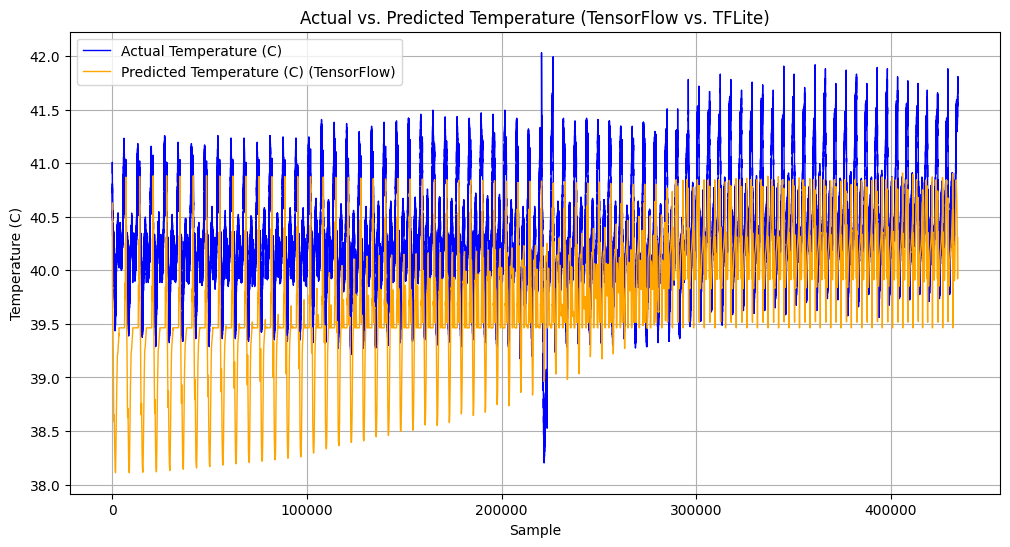

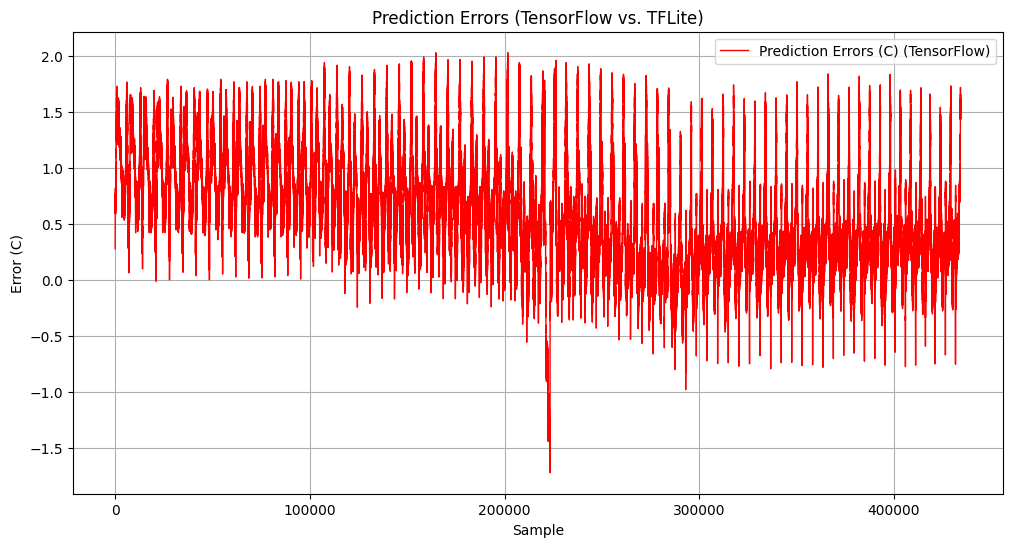


TensorFlow Model - MAE: 0.6444 °C, RMSE: 0.7969 °C


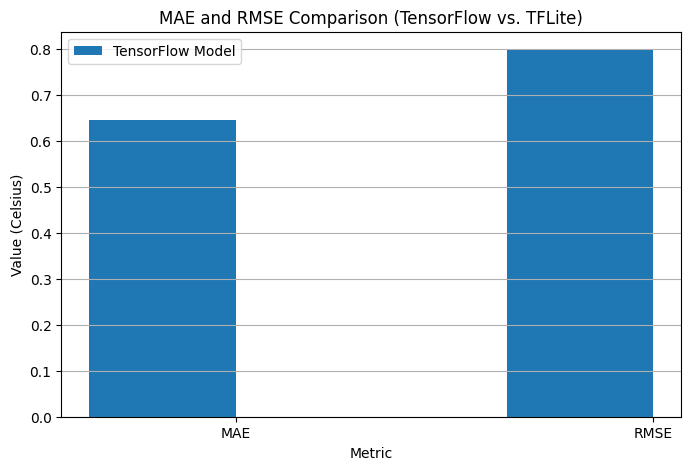

In [12]:
# Define filenames with descriptive names
excel_file = os.path.join(results_folder, "Model_Comparison_TensorFlow_vs_TFLite.xlsx")
plot_filename_actual_vs_pred = os.path.join(results_folder, 'Actual_vs_Predictions_TF_TFLite.png')
plot_filename_errors = os.path.join(results_folder, 'Prediction_Errors_TF_TFLite.png')
plot_filename_mae_rmse = os.path.join(results_folder, 'MAE_RMSE_Comparison_TF_TFLite.png')

# ==============================
# Limit the test dataset to 40,000 samples
# ==============================
num_test_samples = len(X_test)
X_test_limited = X_test[:num_test_samples]
y_test_limited = y_test[:num_test_samples]

# ==============================
# Load the original TensorFlow model
# ==============================
model_path = checkpoint_path
model = tf.keras.models.load_model(model_path)

# Run inference using the original TensorFlow model
print("\nPredicting with TensorFlow model...")
model_preds_test = model.predict(X_test_limited, verbose=1)

# ==============================
# Load the quantized TFLite model
# ==============================
# tflite_model_path = os.path.join(exp_folder, "model.tflite")
# interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
# interpreter.allocate_tensors()

# # Get input and output details
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# Run inference using the quantized model with tqdm
# tflite_preds = []
# print("\nPredicting with TFLite model...")
# for i in tqdm(range(len(X_test_limited)), desc="Processing", unit="sample"):
#     input_data = np.expand_dims(X_test_limited[i], axis=0).astype(np.float32)
#     interpreter.set_tensor(input_details[0]['index'], input_data)
#     interpreter.invoke()
#     output_data = interpreter.get_tensor(output_details[0]['index'])
#     tflite_preds.append(output_data[0])

# Convert predictions to numpy arrays
# tflite_preds = np.array(tflite_preds)

# ==============================
# Convert normalized values to original scale
# ==============================
labels_test_original = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_test_limited), len(features))), y_test_limited.reshape(-1, 1)])
)[:, -1]

model_preds_test_original = scaler.inverse_transform(
    np.hstack([np.zeros((len(model_preds_test), len(features))), model_preds_test])
)[:, -1]

# tflite_preds_original = scaler.inverse_transform(
#     np.hstack([np.zeros((len(tflite_preds), len(features))), tflite_preds])
# )[:, -1]

# ==============================
# Calculate errors
# ==============================
errors_model = labels_test_original - model_preds_test_original
# errors_tflite = labels_test_original - tflite_preds_original

# ==============================
# Create a comparison DataFrame
# ==============================
comparison_df = pd.DataFrame({
    "Sample_Index": range(1, len(labels_test_original) + 1),
    "Actual (C)": labels_test_original,
    "Model_Pred (C)": model_preds_test_original,
    # "TFLite_Pred (C)": tflite_preds_original,
})

comparison_df["Error_Model"] = comparison_df["Actual (C)"] - comparison_df["Model_Pred (C)"]
# comparison_df["Error_TFLite"] = comparison_df["Actual (C)"] - comparison_df["TFLite_Pred (C)"]

# Create columns to check if the error exceeds 5 degrees
comparison_df["Error_Model>5"] = abs(comparison_df["Error_Model"]) > 5
# comparison_df["Error_TFLite>5"] = abs(comparison_df["Error_TFLite"]) > 5

# ==============================
# Save the comparison DataFrame to an Excel file with formatting
# ==============================
comparison_df.to_excel(excel_file, index=False)

# Highlight rows with errors > 5 in the Excel file
wb = load_workbook(excel_file)
ws = wb.active
red_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")

for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
    if row[-2].value:  # "Error_Model>5"
        row[-4].fill = red_fill  # Highlight "Error_Model"
    if row[-1].value:  # "Error_TFLite>5"
        row[-3].fill = red_fill  # Highlight "Error_TFLite"

wb.save(excel_file)
print(f"Comparison file saved: {excel_file}")

# ==============================
# Plot actual vs. predicted temperatures for both models
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(labels_test_original, label="Actual Temperature (C)", color="blue", linewidth=1)
plt.plot(model_preds_test_original, label="Predicted Temperature (C) (TensorFlow)", color="orange", linewidth=1)
# plt.plot(tflite_preds_original, label="Predicted Temperature (C) (TFLite)", color="green", linewidth=1)
plt.title("Actual vs. Predicted Temperature (TensorFlow vs. TFLite)")
plt.xlabel("Sample")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid(True)
plt.savefig(plot_filename_actual_vs_pred, pad_inches=0, bbox_inches='tight')
plt.show()

# ==============================
# Plot prediction errors for both models
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(errors_model, label="Prediction Errors (C) (TensorFlow)", color="red", linewidth=1)
# plt.plot(errors_tflite, label="Prediction Errors (C) (TFLite)", color="purple", linewidth=1)
plt.title("Prediction Errors (TensorFlow vs. TFLite)")
plt.xlabel("Sample")
plt.ylabel("Error (C)")
plt.legend()
plt.grid(True)
plt.savefig(plot_filename_errors, pad_inches=0.1, bbox_inches='tight')
plt.show()

# ==============================
# Calculate MAE and RMSE for both models
# ==============================
mae_model = mean_absolute_error(labels_test_original, model_preds_test_original)
rmse_model = np.sqrt(mean_squared_error(labels_test_original, model_preds_test_original))

# mae_tflite = mean_absolute_error(labels_test_original, tflite_preds_original)
# rmse_tflite = np.sqrt(mean_squared_error(labels_test_original, tflite_preds_original))

# Print the results
print(f"\nTensorFlow Model - MAE: {mae_model:.4f} °C, RMSE: {rmse_model:.4f} °C")
# print(f"TFLite Model - MAE: {mae_tflite:.4f} °C, RMSE: {rmse_tflite:.4f} °C")

# ==============================
# Plot MAE and RMSE comparison
# ==============================
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE"],
    "TensorFlow": [mae_model, rmse_model],
    # "TFLite": [mae_tflite, rmse_tflite]
})

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(metrics_df))

plt.bar(index, metrics_df["TensorFlow"], bar_width, label="TensorFlow Model")
# plt.bar(index + bar_width, metrics_df["TFLite"], bar_width, label="TFLite Model")

plt.xlabel("Metric")
plt.ylabel("Value (Celsius)")
plt.title("MAE and RMSE Comparison (TensorFlow vs. TFLite)")
plt.xticks(index + bar_width / 2, metrics_df["Metric"])
plt.legend()
plt.grid(True, axis='y')
plt.savefig(plot_filename_mae_rmse, pad_inches=0, bbox_inches='tight')
plt.show()



# ESP32 Integration and Progress Tracking

In [8]:
import serial
import pickle

# Path to store progress
progress_file = os.path.join(results_folder, "progress_data.pkl")


# Load previous progress if available
if os.path.exists(progress_file):
    with open(progress_file, "rb") as f:
        progress_data = pickle.load(f)
        start_index = progress_data.get("last_index", 0)
        esp_preds_scaled = progress_data.get("esp_preds_scaled", [])
        model_preds_scaled = progress_data.get("model_preds_scaled", [])
        labels_scaled = progress_data.get("labels_scaled", [])
else:
    start_index = 0
    esp_preds_scaled = []
    model_preds_scaled = []
    labels_scaled = []

run_on_esp = False

if run_on_esp:
    # Serial connection settings for ESP32
    ESP32_PORT = "/dev/ttyACM0"  # Adjust based on your system
    BAUD_RATE = 115200
    esp = serial.Serial(ESP32_PORT, BAUD_RATE, timeout=5)

    # Process data
    for i, sequence in enumerate(tqdm(X_test[start_index:], desc="Processing Data", unit="sequence", initial=start_index, total=len(X_test))):
        index = i + start_index  # Adjust index relative to the full dataset

        # ===========================
        # 1) Model prediction in Python
        # ===========================
        sequence_expanded = np.expand_dims(sequence, axis=0)
        local_pred = model.predict(sequence_expanded, verbose=0)  # Shape: (1, 1)
        local_pred_val = local_pred[0, 0]  # Extract the predicted value (normalized scale)

        model_preds_scaled.append(local_pred_val)
        labels_scaled.append(y_test[index])  # Append the true value (normalized scale)

        # ===========================
        # 2) Send data to ESP32
        # ===========================
        flattened = sequence.flatten()
        payload = ",".join(map(str, flattened))
        max_retries = 3  # Maximum number of retries
        retries = 0
        esp_pred_val = np.nan  # Default value in case of failure

        while retries < max_retries:
            try:
                esp.write((payload + "\n").encode())

                raw_response = esp.readline()
                response = raw_response.decode().strip()
                match = re.search(r"Predicted Temperature:\s*(-?\d*\.\d+|-?\d+)", response)

                if match:
                    esp_pred_val = float(match.group(1))
                    break  # Exit the loop if successful
                else:
                    raise ValueError(f"No numeric value found in response: {response}")

            except Exception as e:
                retries += 1
                print(f"Error decoding ESP32 response for sample {index + 1}, attempt {retries}: {e}. Raw response: {raw_response}")

        if retries == max_retries:
            print(f"Failed to get valid response from ESP32 for sample {index + 1} after {max_retries} attempts.")
            
        esp_preds_scaled.append(esp_pred_val)

        # ===========================
        # Save progress
        # ===========================
        progress_data = {
            "last_index": index + 1,
            "esp_preds_scaled": esp_preds_scaled,
            "model_preds_scaled": model_preds_scaled,
            "labels_scaled": labels_scaled,
        }
        with open(progress_file, "wb") as f:
            pickle.dump(progress_data, f)

    # Close ESP32 connection
    esp.close()


# Output Creation, Comparison, and Visualization

In [9]:
create_outputs = True
    
if create_outputs:
    
    # Define filenames with descriptive names
    excel_file = os.path.join(results_folder, "Comparison_TensorFlow_vs_ESP32.xlsx")
    plot_filename_actual_vs_pred = os.path.join(results_folder, 'Actual_vs_Model_vs_ESP32.png')
    plot_filename_errors = os.path.join(results_folder, 'Prediction_Errors_Model_vs_ESP32.png')
    plot_filename_mae_rmse = os.path.join(results_folder, 'MAE_RMSE_Comparison_Model_vs_ESP32.png')
        
    labels_scaled_arr = np.array(labels_scaled).reshape(-1, 1)
    model_preds_scaled_arr = np.array(model_preds_scaled).reshape(-1, 1)
    esp_preds_scaled_arr = np.array(esp_preds_scaled).reshape(-1, 1)

    num_features = len(features)
    zeros_for_features = np.zeros((len(labels_scaled_arr), num_features))

    labels_original = scaler.inverse_transform(np.hstack([zeros_for_features, labels_scaled_arr]))[:, -1]
    model_preds_original = scaler.inverse_transform(np.hstack([zeros_for_features, model_preds_scaled_arr]))[:, -1]
    esp_preds_original = scaler.inverse_transform(np.hstack([zeros_for_features, esp_preds_scaled_arr]))[:, -1]

    # ==============================
    # Create a comparison DataFrame
    # ==============================
    comparison_df = pd.DataFrame({
        "Sample_Index": range(1, len(labels_original) + 1),
        "Actual (C)": labels_original,
        "Model_Pred (C)": model_preds_original,
        "ESP_Pred (C)": esp_preds_original,
    })

    comparison_df["Error_Model"] = comparison_df["Actual (C)"] - comparison_df["Model_Pred (C)"]
    comparison_df["Error_ESP"] = comparison_df["Actual (C)"] - comparison_df["ESP_Pred (C)"]

    # Create columns to check if the error exceeds 5 degrees
    comparison_df["Error_Model>5"] = abs(comparison_df["Error_Model"]) > 5
    comparison_df["Error_ESP>5"] = abs(comparison_df["Error_ESP"]) > 5

    # ==============================
    # Save the comparison DataFrame to an Excel file with formatting
    # ==============================
    comparison_df.to_excel(excel_file, index=False)

    # Highlight rows with errors > 5 in the Excel file
    wb = load_workbook(excel_file)
    ws = wb.active
    red_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")

    for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
        if row[-2].value:  # "Error_Model>5"
            row[-4].fill = red_fill  # Highlight "Error_Model"
        if row[-1].value:  # "Error_ESP>5"
            row[-3].fill = red_fill  # Highlight "Error_ESP"

    wb.save(excel_file)
    print(f"Comparison file saved: {excel_file}")

    # ==============================
    # Plot comparison charts
    # ==============================
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df["Actual (C)"], label="Actual Temperature (C)", color="blue", linewidth=1)
    plt.plot(comparison_df["Model_Pred (C)"], label="Predicted by TensorFlow Model (C)", color="orange", linewidth=1)
    plt.plot(comparison_df["ESP_Pred (C)"], label="Predicted by ESP32 (TensorFlow Lite) (C)", color="green", linewidth=1)
    plt.title("Actual vs. Model Prediction vs. ESP32 Prediction")
    plt.xlabel("Sample")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_filename_actual_vs_pred, pad_inches=0, bbox_inches='tight')
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df["Error_Model"], label="Error: TensorFlow Model (C)", color="red", linewidth=1)
    plt.plot(comparison_df["Error_ESP"], label="Error: ESP32 (TensorFlow Lite) (C)", color="purple", linewidth=1)
    plt.title("Error Comparison: TensorFlow Model vs. ESP32")
    plt.xlabel("Sample")
    plt.ylabel("Error (C)")
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_filename_errors, pad_inches=0.1, bbox_inches='tight')
    plt.show()

    
    # ==============================
    # Calculate MAE and RMSE
    # ==============================

    comparison_df = comparison_df.dropna(subset=["Actual (C)", "ESP_Pred (C)", "Model_Pred (C)"])
    
    mae_model = mean_absolute_error(comparison_df["Actual (C)"], comparison_df["Model_Pred (C)"])
    rmse_model = np.sqrt(mean_squared_error(comparison_df["Actual (C)"], comparison_df["Model_Pred (C)"]))

    mae_esp = mean_absolute_error(comparison_df["Actual (C)"], comparison_df["ESP_Pred (C)"])
    rmse_esp = np.sqrt(mean_squared_error(comparison_df["Actual (C)"], comparison_df["ESP_Pred (C)"]))

    # Print the results
    print(f"Model MAE: {mae_model:.2f}, RMSE: {rmse_model:.2f}")
    print(f"ESP32 MAE: {mae_esp:.2f}, RMSE: {rmse_esp:.2f}")

    # ==============================
    # Plot MAE and RMSE comparison
    # ==============================
    metrics_df = pd.DataFrame({
        "Metric": ["MAE", "RMSE"],
        "Model": [mae_model, rmse_model],
        "ESP32": [mae_esp, rmse_esp]
    })

    plt.figure(figsize=(8, 5))
    bar_width = 0.35
    index = np.arange(len(metrics_df))

    plt.bar(index, metrics_df["Model"], bar_width, label="TensorFlow Model")
    plt.bar(index + bar_width, metrics_df["ESP32"], bar_width, label="ESP32 (TensorFlow Lite)")

    plt.xlabel("Metric")
    plt.ylabel("Value (Celsius)")
    plt.title("MAE and RMSE Comparison (in Celsius): TensorFlow Model vs ESP32")
    plt.xticks(index + bar_width / 2, metrics_df["Metric"])
    plt.legend()
    plt.grid(True, axis='y')

    plt.savefig(plot_filename_mae_rmse, pad_inches=0, bbox_inches='tight')
    plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.